In [ ]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np

import datetime

import nltk
nltk.downloader.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
agent_info = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}

In [ ]:
finviz_url = "https://finviz.com/quote.ashx?t="

tickers = ["LCID","XPEV"]

news_tables = {}

for t in tickers:
    print(t)
    url =finviz_url + t
    print(url)
    t_content = requests.get(url, headers = agent_info)
    content_bs = bs(t_content.content, "html")
    news_tab = content_bs.find(id="news-table")
    news_tables[t] =news_tab
    print("-"*10)

LCID
https://finviz.com/quote.ashx?t=LCID
----------
XPEV
https://finviz.com/quote.ashx?t=XPEV
----------


In [ ]:
table_array = []

for name, news_table in news_tables.items():
    print(name)

    for x in news_table.findAll('tr'):
        try:
          #headline
          text_content = x.a.get_text()
          #dates
          date_content = x.td.text.split()

          if len(date_content) == 1:
              time = date_content[0]
          else:
              date= date_content[0]
              time = date_content[1]

          table_array.append([name,date, time, text_content])
        except:
          print("Some items cannot be parsed")

LCID
Some items cannot be parsed
Some items cannot be parsed
Some items cannot be parsed
XPEV
Some items cannot be parsed
Some items cannot be parsed
Some items cannot be parsed


In [ ]:
table_news = pd.DataFrame(table_array, columns=["Ticker","Date","Time","Headline"])

table_news['Date'] = np.where(table_news['Date']=="Today", datetime.date.today(), table_news['Date'])
table_news['Date'] = pd.to_datetime(table_news['Date']).dt.date

table_news.head()

,Ticker,Date,Time,Headline
0,LCID,2023-11-02,04:17PM,"Beyond Meat layoffs, Lucid referral program: T..."
1,LCID,2023-10-27,06:25AM,Lucid Motors Can Still Be the Next Tesla. Here...
2,LCID,2023-10-23,09:00AM,Lucid Introduces U.S. Referral Program Benefit...
3,LCID,2023-10-19,04:39PM,Tesla Stock Sells Off After Musk Tempers Cyber...
4,LCID,2023-10-19,01:39PM,"Tesla Stock, Other EV Makers Sell Off After Mu..."


#### Sentiment Analysis with NLTK

In [ ]:
#Instaniate the analyzer
vader = SentimentIntensityAnalyzer()



In [ ]:
sentiment_output =  table_news['Headline'].apply(vader.polarity_scores).tolist()

sentiment_df = pd.DataFrame(sentiment_output)

table_news1 = table_news.join(sentiment_df)

In [ ]:
sentiment_output[0:2]

[{'neg': 0.0, 'neu': 0.795, 'pos': 0.205, 'compound': 0.2023},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]

In [ ]:
sentiment_df.head(2)

,neg,neu,pos,compound
0,0.0,0.795,0.205,0.2023
1,0.0,1.000,0.000,0.0000


In [ ]:
table_news1 = table_news1[table_news1.Date>datetime.date(2023, 7, 31)]

In [ ]:
table_news2 = table_news1.groupby(["Ticker", "Date"]).mean().unstack().xs("compound", axis="columns").transpose()

<ipython-input-15-d56c4781b1ca>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_news2 = table_news1.groupby(["Ticker", "Date"]).mean().unstack().xs("compound", axis="columns").transpose()


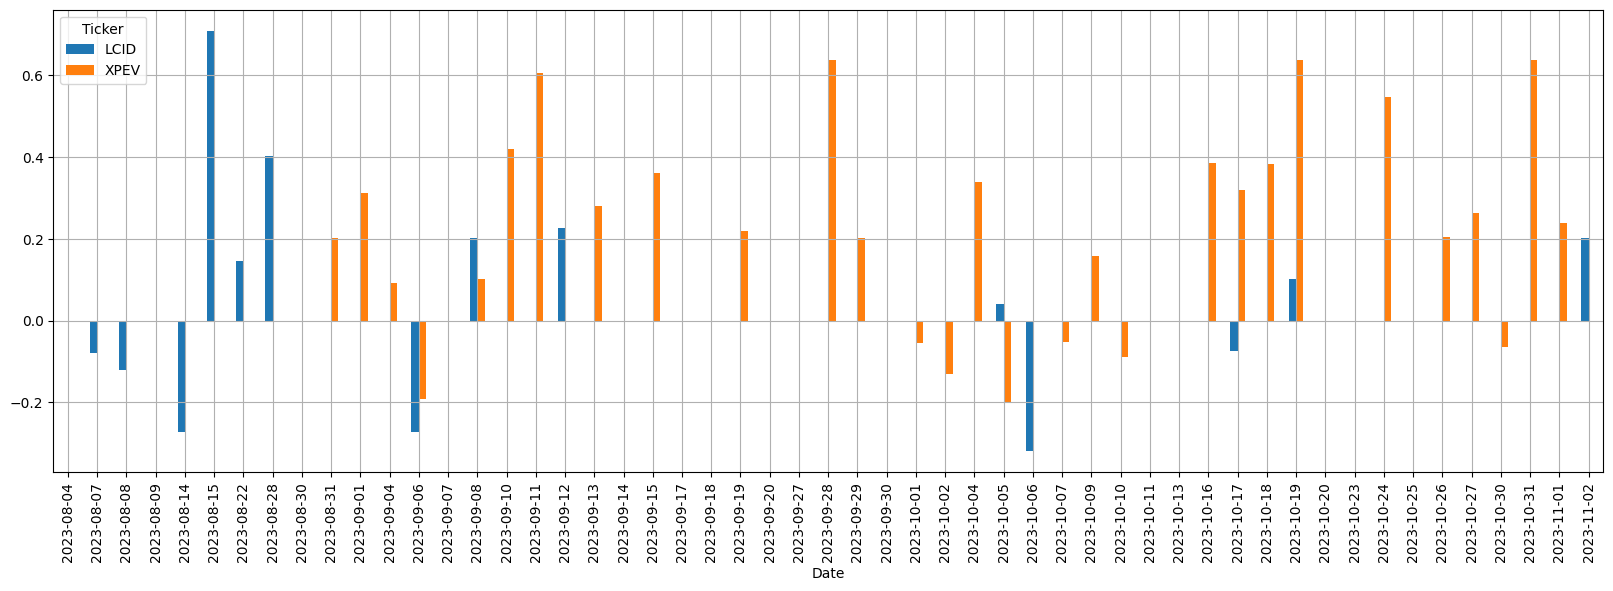

In [ ]:
plt.rcParams['figure.figsize'] =[20, 6]

table_news2.plot(kind="bar")
plt.grid()

In [ ]:
lucid_price = yf.download('LCID', start = "2023-08-04", end ="2023-10-06")
lucid_price_data = lucid_price['Adj Close']

xpev_price = yf.download('XPEV', start = "2023-08-04", end ="2023-10-06")
xpev_price_data = xpev_price['Adj Close']

price_df = pd.DataFrame({'Date': lucid_price_data.index,
             'Price_Lucid': lucid_price_data.to_list(),
             'Price_Xpeng': xpev_price_data.to_list()})

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<BarContainer object of 53 artists>

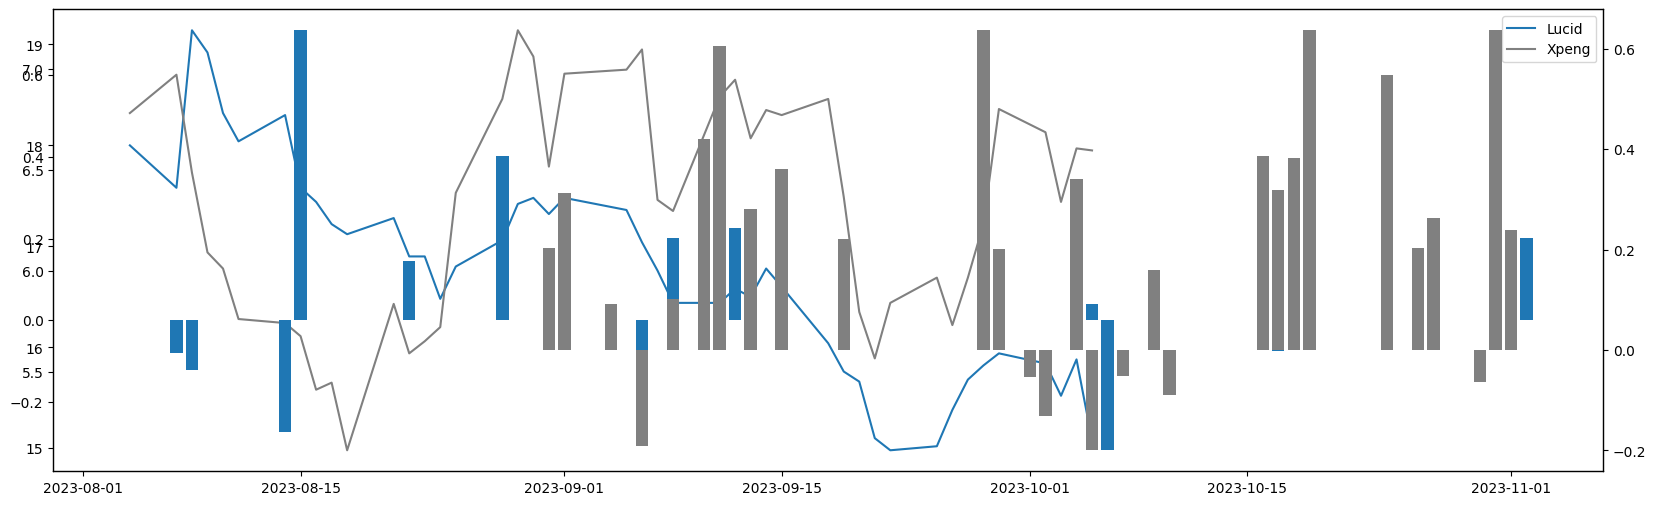

In [ ]:
fig, ax1 =plt.subplots(figsize=(20,6))
l1, = ax1.plot(price_df['Date'], price_df['Price_Lucid'], label="Lucid Price")
ax2 = ax1.twinx()
l2, = ax2.plot(price_df['Date'], price_df['Price_Xpeng'], label="Xpeng Price",color ="grey")
ax2.legend([l1,l2],['Lucid','Xpeng'])

ax3 = ax2.twinx()
ax3.bar(table_news2.index, table_news2.LCID)

ax4 = ax3.twinx()
ax4.bar(table_news2.index, table_news2.XPEV,color ="grey")

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")


In [ ]:
sentiment_output = table_news['Headline'].apply(pipe).tolist()
sentiment_df = pd.DataFrame(sentiment_output)
sentiment_df

,0
0,"{'label': 'neutral', 'score': 0.999872088432312}"
1,"{'label': 'neutral', 'score': 0.9998311996459961}"
2,"{'label': 'neutral', 'score': 0.9948074221611023}"
3,"{'label': 'negative', 'score': 0.9972702860832..."
4,"{'label': 'negative', 'score': 0.9968388080596..."
...,...
195,"{'label': 'neutral', 'score': 0.9998199343681335}"
196,"{'label': 'positive', 'score': 0.9994582533836..."
197,"{'label': 'neutral', 'score': 0.999886155128479}"
198,"{'label': 'neutral', 'score': 0.9997338652610779}"


In [ ]:
def process_score(x):
    if x['label'] =="neutral":
        score = 0
    elif x['label']  =="positive":
        score = x['score']
    elif x['label']  =="negative":
        score = x['score']*-1

    return score

sentiment_series = sentiment_df[0].apply(process_score)
sentiment_series

0      0.000000
1      0.000000
2      0.000000
3     -0.997270
4     -0.996839
         ...   
195    0.000000
196    0.999458
197    0.000000
198    0.000000
199    0.000000
Name: 0, Length: 200, dtype: float64

In [ ]:
# #merge the news content with sentiment outputs
table_news1 = table_news.join(sentiment_series)

table_news2 = table_news1.groupby(['Ticker','Date']).mean().unstack().xs(0, axis="columns").transpose()

<ipython-input-24-6a433a43df0f>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_news2 = table_news1.groupby(['Ticker','Date']).mean().unstack().xs(0, axis="columns").transpose()


In [ ]:
table_news2 = table_news2[table_news2.index>datetime.date(2023, 7, 31)]

<BarContainer object of 53 artists>

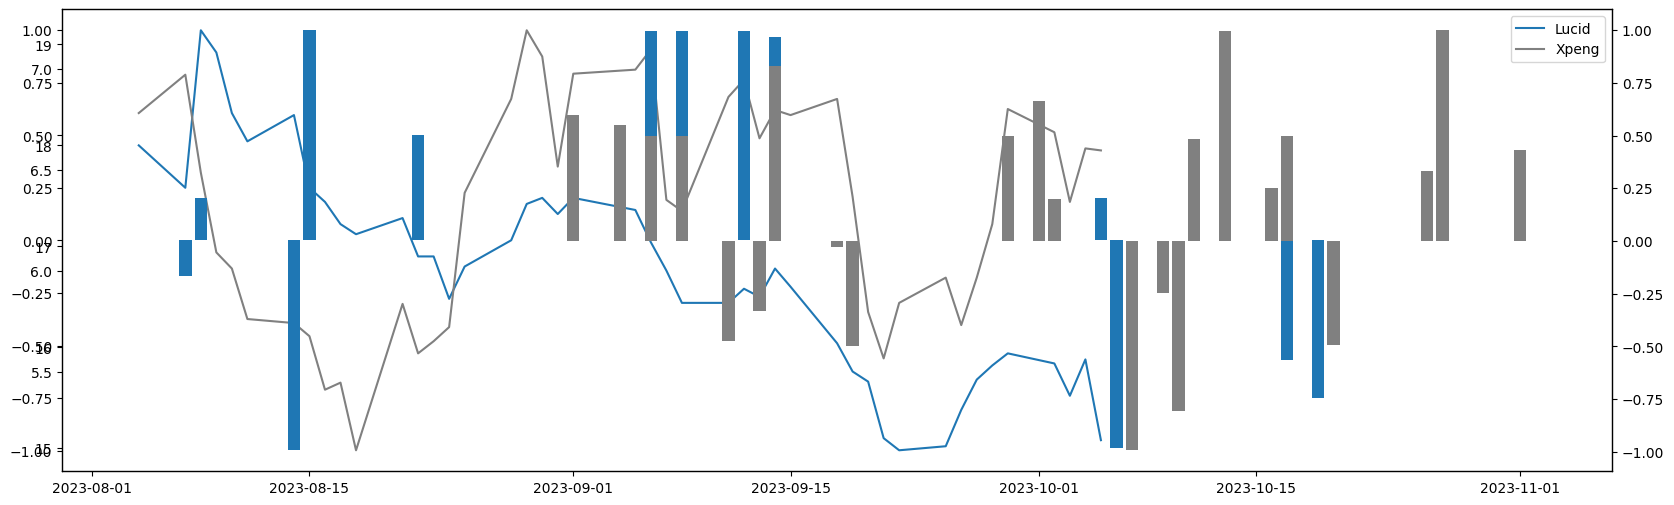

In [ ]:
fig, ax1 =plt.subplots(figsize=(20,6))
l1, = ax1.plot(price_df['Date'], price_df['Price_Lucid'], label="Lucid Price")
ax2 = ax1.twinx()
l2, = ax2.plot(price_df['Date'], price_df['Price_Xpeng'], label="Xpeng Price",color ="grey")
ax2.legend([l1,l2],['Lucid','Xpeng'])

ax3 = ax2.twinx()
ax3.bar(table_news2.index, table_news2.LCID)

ax4 = ax3.twinx()
ax4.bar(table_news2.index, table_news2.XPEV,color ="grey")